# TensorFlow 2.0

In [1]:
import os
from glob import glob
from datetime import datetime

import numpy as np

import tensorflow as tf
from tensorflow.keras import layers

from tensorflow.keras import datasets 

import matplotlib.pyplot as plt

%matplotlib inline

## Hyperparameter Tunning

In [2]:
num_epochs = 20
batch_size = 32

learning_rate = 0.001

dropout_rate = 0.5

input_shape = (32, 32, 3)
num_classes = 10

## Build Model

In [3]:
inputs = layers.Input(input_shape)

net = layers.Conv2D(32, (3, 3), padding='SAME')(inputs)
net = layers.Activation('relu')(net)
net = layers.Conv2D(32, (3, 3), padding='SAME')(net)
net = layers.Activation('relu')(net)
net = layers.MaxPooling2D(pool_size=(2, 2))(net)
net = layers.Dropout(dropout_rate)(net)

net = layers.Conv2D(64, (3, 3), padding='SAME')(net)
net = layers.Activation('relu')(net)
net = layers.Conv2D(64, (3, 3), padding='SAME')(net)
net = layers.Activation('relu')(net)
net = layers.MaxPooling2D(pool_size=(2, 2))(net)
net = layers.Dropout(dropout_rate)(net)

net = layers.Flatten()(net)
net = layers.Dense(512)(net)
net = layers.Activation('relu')(net)
net = layers.Dropout(dropout_rate)(net)
net = layers.Dense(num_classes)(net)
net = layers.Activation('softmax')(net)

model = tf.keras.Model(inputs=inputs, outputs=net, name='Basic_CNN')

In [4]:
# Model is the full model w/o custom layers
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),  # Optimization
              loss='sparse_categorical_crossentropy',  # Loss Function 
              metrics=['accuracy'])  # Metrics / Accuracy

# Data Preprocess

In [5]:
train_paths = glob(r'C:\Users\LG\Deep_Learning_Study\Tensorflow\dataset\cifar\train\*.png')[:100]
test_paths = glob(r'C:\Users\LG\Deep_Learning_Study\Tensorflow\dataset\cifar\test\*.png')[:100]

In [6]:
def get_class_name(path):
    return path.split('_')[-1].replace('.png', '')

In [7]:
train_labels = [get_class_name(path) for path in train_paths]
class_names = np.unique(train_labels)

In [8]:
def get_label(path):
    fname = tf.strings.split(path, '_')[-1]
    lbl_name = tf.strings.regex_replace(fname, '.png', '')
    onehot = tf.cast(lbl_name == class_names, tf.uint8)
    return tf.argmax(onehot)  # 이번에는 onehot이 아닌 label 번호로

In [9]:
def load_image_label(path):
    gfile = tf.io.read_file(path)
    image = tf.io.decode_image(gfile)
    image = tf.cast(image, tf.float32) / 255.  # rescale
    
    label = get_label(path)
    return image, label

In [10]:
def image_preprocess(image, label):
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_flip_left_right(image)
    return image, label

In [11]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [12]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_paths)
train_dataset = train_dataset.map(load_image_label, num_parallel_calls=AUTOTUNE)
train_dataset = train_dataset.map(image_preprocess, num_parallel_calls=AUTOTUNE)
train_dataset = train_dataset.batch(batch_size)
train_dataset = train_dataset.shuffle(buffer_size=len(train_paths))
train_dataset = train_dataset.repeat()

In [13]:
test_dataset = tf.data.Dataset.from_tensor_slices(test_paths)
test_dataset = test_dataset.map(load_image_label, num_parallel_calls=AUTOTUNE)
test_dataset = test_dataset.batch(batch_size)
test_dataset = test_dataset.repeat()

# Learning Rate Scheduler

In [14]:
import math

In [15]:
def scheduler(epoch):
    if epoch < 10:
        return 0.001
    else:
        return 0.001 * math.exp(0.1 * (10 - epoch))

In [17]:
for epoch in range(10, 20):
    print(0.001 * math.exp(0.1 * (10 - epoch)))

0.001
0.0009048374180359595
0.0008187307530779819
0.0007408182206817179
0.0006703200460356394
0.0006065306597126335
0.0005488116360940264
0.0004965853037914095
0.0004493289641172216
0.00040656965974059914


In [18]:
lr_list = [0.001 * math.exp(0.1 * (10 - lr)) for lr in range(0, 100)]
len(lr_list)

100

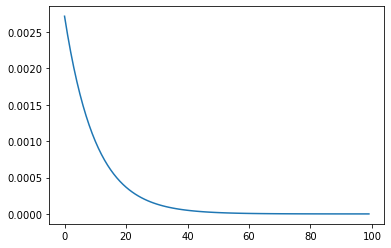

In [19]:
plt.plot(lr_list)
plt.show()

**Another Example : customize**
> ```python
def scheduler(epoch):
    if epoch > 10 and epoch < 20:
        return 0.0001
    elif epoch >= 20:
        retun 0.00001
```

In [25]:
tf.keras.callbacks.LearningRateScheduler(scheduler, verbose=1) # verbos=1이면 learning rate를 출력해줌

In [27]:
learning_rate_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler, verbose=1)

## Training

In [28]:
steps_per_epoch = len(train_paths) // batch_size
validation_steps = len(test_paths) // batch_size

model.fit_generator(
    train_dataset,
    steps_per_epoch=steps_per_epoch,
    validation_data=test_dataset,
    validation_steps=validation_steps,
    epochs=num_epochs,
    callbacks=[learning_rate_scheduler]
)


Epoch 00001: LearningRateScheduler reducing learning rate to 0.001.
Epoch 1/20
3/3 [==============================] - 1s 370ms/step - loss: 1.8026 - accuracy: 0.2647 - val_loss: 2.5496 - val_accuracy: 0.1979

Epoch 00002: LearningRateScheduler reducing learning rate to 0.001.
Epoch 2/20
3/3 [==============================] - 1s 356ms/step - loss: 2.2230 - accuracy: 0.2396 - val_loss: 2.4317 - val_accuracy: 0.2188

Epoch 00003: LearningRateScheduler reducing learning rate to 0.001.
Epoch 3/20
3/3 [==============================] - 1s 280ms/step - loss: 1.4849 - accuracy: 0.3750 - val_loss: 2.7199 - val_accuracy: 0.1562

Epoch 00004: LearningRateScheduler reducing learning rate to 0.001.
Epoch 4/20
3/3 [==============================] - 1s 344ms/step - loss: 2.4885 - accuracy: 0.1458 - val_loss: 2.3292 - val_accuracy: 0.1771

Epoch 00005: LearningRateScheduler reducing learning rate to 0.001.
Epoch 5/20
3/3 [==============================] - 1s 325ms/step - loss: 1.8560 - accuracy: 0.19